# Apple Sentiment Analysis
---
**Authors:** [Chris O'Malley](https://github.com/chriso2672), [Ted Brandon](https://github.com/theobigdog), [Kelsey Lane](https://github.com/kelsklane)

## Overview
---
This project uses data scrapped from [Twitter by CrowdFlower](https://data.world/crowdflower/brands-and-product-emotions) that contains positive, neutral, and negative sentiment towards Apple and Google products. These tweets were scrapped from various #sxsw hashtags on August 30, 2013. We aim to help Apple's product team get a better sense of how consumers reacted to their presentation to better understand the market and how they could improve their product. We did this by using sentiment analysis to gauge the reaction to their presentations and created a model that can assign sentiment to new tweets to help Apple understand how their products are recieved on the course to launch.

## Technical Understanding
---
In this notebook we used only the tweets scrapped from the [CrowdFlower Twitter dataset](https://data.world/crowdflower/brands-and-product-emotions) that pretained to Apple, as that is the company we are targeting in our analysis. After loading in the data with pandas, that left us with 5,428 tweets and their predetermined sentiment. Using regex we cleaned the tweets of any odd characters and leftover artifacts from scrapping like links. After using the Tweet tokenizer from nltk we kept the text in uppercase and kept stopwords, as this combination resulted in the best fit for out model. Any non-relevant punctuation was then removed and the final tokens were lemmatized using the required libraries from nltk. From sklearn we used both a DecisionTreeClassifier as well as MultinomialNB and ComplementNB to model the data, as Bayes models work well with text data and a decision tree was another good simpler model that would give us a comparison. Furthermore, we felt opting for simpler model options and avoiding more computationally exhaustive ones like XGBoost would be a good call, as we have limited computation power and if this was to theoretically scale, a simpler model would be better. For the decision tree we tuned the depth of the tree, the minimum number of samples needed to split, and the criterion used. As for multinomial Bayes we compared CountVectorizer with the Tfidfvectorizer and adjusted the threshold for the max number of features vectorized, as well as the percentage cutoff for the maximum of the data and number of features returned for both vectorizers. Our final model that performed the best was the Complement Naive Bayes model with a Tfidfvectorizer that lopped off the top 50% most frequent words. Of the models it was the least overfit when checking with cross validation and still performed well. The final accurracy of the model on the testing set was 62%.

# DELETE THIS: Just for reference for now
The notebook should include a summary at the beginning that briefly and accurately describes your process. The summary should be approximately 250 words -- about the size of a research paper abstract.

Summary elements:

Business and data understanding:
- what kind of data are you using, and what makes it well-suited for the business problem?
- You do not need to include any data visualizations in your summary, but consider including relevant descriptive statistics

Data preparation:
- why did you choose the data preparation steps that you did, and what was the result?
- This should be specific to the kind of data you are working with. For example, if you are doing an NLP project, what did you decide to do with stopwords?
- Be sure to list the packages/libraries used to prepare the data, and why

Modeling: 
- what modeling package(s) did you use, which model(s) within the package(s), and what tuning steps did you take?
- For some projects there may be only one applicable package; you should still briefly explain why this was the appropriate choice

Evaluation: 
- how well did your final model perform?
- Include one or more relevant metrics
- Be sure to briefly describe your validation approach

## Buisness Understanding
---
Humans struggle with assigning sentiment to text, especially with more casual language like is used on Twitter. For example, [researchers found](https://arxiv.org/abs/1602.07563) that it is very rare for people to completly agree on the sentiment of a tweet, with annotaters agreeing with another about a tweet anywhere from 12 to 67% of the time. Therefore, sentiment can be something very hard to assign, but can be super helpful to companies for gauging their consumers reactions to new products. 

Therefore, we aim to help Apple's product team gain better insight into the consumer's reactions to their SXSW announcement to be able to get a better understanding of how their product was recieved and, going forward, people's reactions to their new announcements. As a result, they can use this information to understand how well recieved and new products are, as well as be able to target consumers who are neutral to their products to be able to convert them to buyers and positive points. As a result, Apple's product team can make better informed decisions about their products moving forward and can also adjust their marketing strategies to capture a wider audience.

## Data Understanding
---
The dataset used for this project was scrapped by Crowdflower on August 30, 2013 and comes from data.world. Originally the dataset contained tweets pretaining to both Apple and Google's presentation at the 2013 SXSW conference and had 9,093 tweets alongside what sentiment a group of people assigned the tweets and towards what product the sentiment was directed. However, as our project is only interested in looking at reactions to Apple products, we narrowed the dataset down to only tweets the pretained to Apple. This leaves us with the subset of tweets that talk about Apple or Apple products somewhere in them. However, within the column that labels the sentiment of the tweet there are ones that are labeled "I can't tell" for the sentiment. As these are unknown and we can't gain any insight from them we opted to drop them. This leaves us with 5,428 tweets to use in the analysis. As the column that describes the target of the sentiment is 60% null values, we opted to drop it and replace it with `what_product`, which we will detail later on. Finally, for legibility we changed the column with the sentiment (`'is_there_an_emotion_directed_at_a_brand_or_product'`) to label to make it easier to read and mapped the targets to 0 for negative, 1 for positive, and 2 for neutral. Notably, there is a class imbalance where neutral tweets represent 53% of the data, while positive tweets account for about 40% of the data and negative tweets under 8%.

In [98]:
#Import needed modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

#Read in the data
tweets = pd.read_csv('data/clean_tweets.csv', encoding = 'iso-8859-1')

This analysis obviously has some limitations. For one, we sorted out the Google data in order to hone in on Apple, but with this we lose the ability to compare Apple's performance to their competitiors. As the competitions production could impact how Apple's is recieved, this is a nuance that is lost through this analysis. Furthermore, we are limited in the sentiment analysis we have. More granularity to the degree of negative or positive reception could help refine the model more, but that insight is lost given the levels we have. Similarly, the class imbalance of negative tweets makes it difficult to distinguish even with sampling, so this is another feature that limits our project. Finally, this analysis is only based on tweets, but product reception is also talked about on other platforms. Therefore, our analysis would benefit to widening the net to other platforms and building analyzers that work with these text patterns.

## Data Preparation
---
As mentioned above, we got rid of the column that identifies the specific product the tweet is about due to the large number of nulls and general inaccuracy of the column, as with exploration the labels did not seem to match well with the tweet content. Below, we use the what_product function to replace this column with a new one. This assumes that the tweet does not refer to multiple products, which is possible, but from exploration does not seem to happen. The order the function checks for products is also used to try and filter for certain products before others that might occur in the same tweet. This felt like an important feature to include as certain products may have been recieved better while others recieved a stronger negative reaction. Therefore, this feature is included to account for how these differences may affect sentiment. While around 50% of the tweets seem to be about iPads, 20% are about Apple or the iPhone, while apps account for 10% of the tweets, with a very small percentage of tweets not containing any product-specific language.

In [83]:
#Returns a string with the product
def what_product(tweet):
    tweet_check = tweet.lower()
    #Checks for apps before the phone as there is likely a high co-occurrance
    if ('app ' in tweet_check) or ('apps ' in tweet_check):
        return 'App'
    #Checks if tweet is about the iphone
    if ('iphone' in tweet_check) or ('phone' in tweet_check):
        return 'Phone'
    #Checks if the tweet is about the ipad
    if ('ipad' in tweet_check):
        return 'iPad'
    #Anything mentioning Apple returned as company
    if ('apple' in tweet_check):
        return 'Company'
    #Any Apple related tweets that dont mention anything specific lumped to general
    else:
        return 'General'

#Adds product column to the tweets
tweets['what_product'] = tweets['tweet_text'].apply(what_product)

Another feature added is one that keeps track of the ratio of capital letters to other characters in the tweet. This feature was included as the case of the letters is a parameter that gets tweaked during various model iterations, but the presence of capital letters could indicate the sentiment of a tweet. For example, someone whose particularly excited may tweet in all caps compared to someone whose more neutral. Therefore, this information is retained and amplified as its own feature, where the quantity of capital letters is computed as a ratio to the other characters in a tweet so that tweet length doesn't inadvertantly bias the feature.

In [84]:
def capital_letter_ratio(tweet):
    #Initilizes count variable
    capital_count = 0
    #Checks each character in the tweet
    for c in tweet:
        #Increments count if capital letter is present
        if c.isupper():
            capital_count += 1
    return capital_count / len(tweet)

#Adds capital letter ratio column to the tweets
tweets['capital_letter_ratio'] = tweets['tweet_text'].apply(capital_letter_ratio)

Finally, both positive and negative tweets are liable to spam question marks and exclamation points to indicate strong emotion. As punctuation isn't clearly captured in the tokenization process with duplicate marks getting deleted, this function counts up any existing versions of these punctuation marks to retain this information. This is useful as a feature as it can help distinguish tweets with a positive or negative sentiment from a neutral one.

In [88]:
def exc_que_count(tweet):
    #Punctuation to look for
    punctuation = '!?'
    #Initilizes count variable
    count = 0
    #Looks for any punctuation in the string and increments count accordingly
    for p in punctuation:
        count += tweet.count(p)
    return count

#Adds !? count column to the tweets
tweets['exc_que_count'] = tweets['tweet_text'].apply(exc_que_count)

There is one tweet in the dataset with a null tweet value, so this lone row is dropped below.

In [86]:
tweets = tweets.dropna()

While the tokenizer is called later during modeling, the function used to clean and process the tweets into tokens is included below first to walk through its execution. The tokenizer cleans up the text by removing any instances of links or the #sxsw hashtag, as the links don't convey any important meaning and these hashtag variations are what was used to scrape for the tweets, so they're common across all tweets. Next, any non-ASCII character is removed to clean up any non-words. The tweets are then tokenized using nltk's tweet tokenizer and these tokens are then cleaned of any unwanted puntuation or 'rt' "words" that are artifacts left by Twitter to indicate if a tweet retweets another and thus doesn't convey any information. Finally, the tokens are tagged with their part of speech and lemmatized, as tense and other affixes wouldn't contribute any extra information. Therefore, the tokens are stripped of these to help limit dimentionality. Notably, stopwords are not stripped from the text. Through testing different parameters, we found that including stopwords can actually increase model performance.

In [71]:
#Functions to tokenize text
import string

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['#', '?', '!', '@']
punct = [p for p in punct if p not in keep_punct]

#Used to filter rt
common_tweet_words = ['rt']

#Removes non-ASCII characters
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
def tweet_tokenizer(doc):
    #Gets rid of links
    doc = re.sub(r'http\S+', '', doc)
    doc = re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', doc)
    #Gets rid of #sxsw hashtag variations
    doc = re.sub(r'(?i)(#sxsw)\w*', '', doc)
    #Gets rid of conversions made during scrapping
    doc = re.sub(r'{link}', '', doc)
    doc = re.sub(r'\[video\]', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer
    tweet_token = TweetTokenizer(strip_handles = True)
    doc = tweet_token.tokenize(doc)
    #Gets rid of any tokens that represent if the tweet was retweeted
    doc = [w for w in doc if w.lower() not in common_tweet_words]
    #Gets rid  of any punctuation that we don't want to keep
    doc = [w for w in doc if w not in punct]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

Finally, we opted to keep retweets in the dataset despite removing the 'rt' marker. While this may artifically increase certain words so they become overrepresented, we feel that the magnification of sentiment of these tweets was still important information. Of the dataset, 750 tweets included end up being retweeted by other people to account for 1,485 total retweets in the dataset. Therefore, while it may impact the representation of some words in the data, we think the amplified sentiment the retweets supply can help model performance more.

## First Simple Model
---
The first simple model we looked at was a decision tree that only gets fed the tokenized tweets without any additional columns. This was just to get a sense of how a very simple model would work when not supplied with any additional information to establish a baseline.

In [92]:
y = tweets['label']
X = tweets['tweet_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

baseline = imbpipeline(steps=[
    ('preproc', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state=11)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

baseline.fit(X_train, y_train)
print("Training Score:", baseline.score(X_train, y_train))
scores = np.mean(cross_val_score(baseline, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.4431343650208794
Validation Score:0.44387000497429946


## Multinomial Bayes Models
---
The first model type we wanted to test out was Multinomial Bayes, as Bayes models tend to do well with text data and would likely show an improvement over a simple decision tree. As we are not doing binary classification, we opted for Multinomial Bayes and we started with the CountVectorizer as it wasn't clear if weighting the words across different tweets using TF_IDF would yield any additional help to the model. We also included the features created above in order to help improve model performance. Finally, as we have class imbalance affecting tweets with negative sentiment, we opted to SMOTE the minority class.

In [93]:
#Creates features and target then performs train test split
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Creates preprocessing step
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

#Creates pipeline for model
apple_cv = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
apple_cv.fit(X_train, y_train)
print("Training Score:", apple_cv.score(X_train, y_train))
#Cross validates model and prints average result
scores = np.mean(cross_val_score(apple_cv, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.8290346352247605
Validation Score:0.6236776653954569


While the above model improves on the first simple model, it overfits the data as there is a gap of .20 between training and validation scores. To see if we can bring this overfitting down, another Multinomaial Bayes model is run with TF_IDF as the vectorizer to see how that changes the accuracy.

In [12]:
#Creates preprocessing step for pipeline
tfidf_vec = ColumnTransformer([
    ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

#Creates pipeline for model
apple_tfidf = imbpipeline(steps=[
    ('preproc', tfidf_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training and cross validation scores
apple_tfidf.fit(X_train, y_train)
print("Training Score:", apple_tfidf.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_tfidf, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7379022353230165
Validation Score:0.5662009918451636


While the training score goes down, this model overfits less compared to the first, and therefore is the version we proceed with. In order to tune it and try and get an improvement on validation scores, we run this pipeline through a gridserach to try and figure out what parameters in the vectorizer could potentially help reduce the overfitting currently present. We test max features alongside max_df to see if limiting the more and less common words could improve model fit, as well as looking at the inclusion of bigrams to see if they add any additional information and testing case to see its influence on classification.

In [13]:
#Creates parameters to test
params = {
    'preproc__tfidf__max_features': [1000, 4000, 8000, None],
    'preproc__tfidf__max_df': [.75, .85, .95],
    'preproc__tfidf__lowercase': [False, True],
    'preproc__tfidf__ngram_range': [(1,1), (1,2), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(apple_tfidf, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'preproc__tfidf__lowercase': True,
 'preproc__tfidf__max_df': 0.75,
 'preproc__tfidf__max_features': 4000,
 'preproc__tfidf__ngram_range': (1, 1)}

It looks like ignoring terms in the top 25% of frequency, using all lowercase words, and limiting the vectorizer to only 5,000 words while sticking with only unigrams outputs the best performance. While the adjusted model below shows only slight changes in the score, there is still a reduction in overfitting. The training score has also gone down again, but this is still an overall improvement.

In [14]:
y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

tfidf_vec = ColumnTransformer([
    ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = True, tokenizer = tweet_tokenizer, 
                              max_df = .75, max_features = 4000), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

apple_tuned = imbpipeline(steps=[
    ('preproc', tfidf_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

apple_tuned.fit(X_train, y_train)
print("Training Score:", apple_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7160402849422747
Validation Score:0.5689045989659486


The final Bayes model we ran was a Complement Naive Bayes model. This model is built to deal with imbalanced data, so since the negative sentiment tweets make up so few of our data points, we opted to try it out. We went through a similar process to the Multinomial model for tuning the results, and the final model from that is used below. This is ultimately our best model. While there is still a significant amount of overfitting, it is a comparable amount to the final Multinomial Bayes model. Therefore, as the accuracy scores are better this is the final model we decided to go with.

In [90]:
from sklearn.naive_bayes import ComplementNB

y = tweets['label']
X = tweets.drop('label', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

tfidf_vec = ColumnTransformer([
    ('tfidf', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer,
                             max_df = .5, max_features = 4000), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

final = imbpipeline(steps=[
    ('preproc', tfidf_vec),
    ('mnb', ComplementNB())
])

final.fit(X_train, y_train)
print("Training Score:", final.score(X_train, y_train))
scores = np.mean(cross_val_score(final, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.7966101694915254
Validation Score:0.6362077749807811


# Decision Tree Models

While we thought Multinomial Bayes would give us the best result, we also wanted to test out a different classifier to see if we could get any improvement in score. While a simpler decision tree was run above with only tweets, we ran another one with the added features and no hyperparameters to see what the change in score would be. As the TfidfVectorizer performed better with Bayes above, we opted to keep it as the vectorizer here.

In [72]:
#Establishes preprocessing for the decision tree
count_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(encoding = 'iso-8859-1', lowercase = False, tokenizer = tweet_tokenizer), 'tweet_text'),
    ('ohe', OneHotEncoder(), ['what_product'])],
    remainder = 'passthrough')

#Creates decision tree pipeline
apple_dt = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('dtc', DecisionTreeClassifier(random_state = 213))
])

#Fits the new model on the data and prints the score for training and cross validation
apple_dt.fit(X_train, y_train)
print("Training Score:", apple_dt.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_dt, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.9992630803242447
Validation Score:0.5725846761429584


Despite the fantastic training score, the tree is clearly overfitting. In order to tune the tree and hopefully reduce the overfitting, we ran another gridsearch for the decision tree to tune the hypterparameters.

In [76]:
#Creates parameters to test
params = {
    'dtc__max_depth': [None, 20, 30],
    'dtc__criterion': ['gini', 'entropy'],
    'dtc__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(apple_dt, param_grid = params, scoring = 'accuracy', cv = 3)
search.fit(X_train, y_train)
search.best_params_

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 30,
 'dtc__min_samples_split': 2}

These tuned parameters were then fed into the model below. While the overfitting does go down, it's still pretty substantial. Therefore, the final model we opted to go with was the tuned Complement Naive Bayes one above, as it had the least amount of overfitting while still retaining a decent amount of accuracy.

In [77]:
#Adjusts the model in the pipeline to include new parameters
apple_dt_tuned = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('dtc', DecisionTreeClassifier(max_depth = 30, random_state = 213))
])

#Fits the new model and prints out training and validation scores
apple_dt_tuned.fit(X_train, y_train)
print("Training Score:", apple_dt_tuned.score(X_train, y_train))
scores = np.mean(cross_val_score(apple_dt_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score: 0.8658806190125277
Validation Score:0.5779915889118343


## Evaluation
---
As mentioned earlier, the final model we went with was the tuned Complement Naive Bayes model that used the Tfidf vectorizer. We opted for this model over the others as it had the highest accuracy score while maintaining the least amount of differente between training and validation sets, indicating it was the model that overfit the least. The final score of the model based on the test data is printed below.

In [91]:
final.score(X_test, y_test)

0.6219602063375093

Therefore, the final accuracy score of the model is 62%. As for why we have been using accuracy as the metric, it's because in terms of false positives and false negatives for sentiment there's not any one we want to avoid more. As we are trying to get a gauge of customer interest across three different sentiment types, we did not want to avoid one misclassification over the other, as we do not care more for any one particular sentiment. Therefore, we opted for accuracy as our metric to find the model that would perform the best overall. For curiosities sake, the confusion matric for the model is printed below just to see its overall performance.

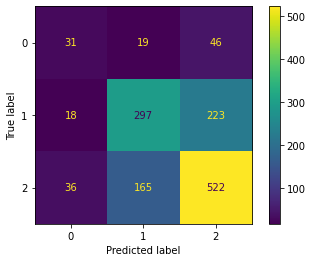

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = final.predict(X_test)
cm = confusion_matrix(y_test, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

While the final model's accuracy has gone up from around 45% to 63%, there is still improvements to be made and also a bit of overfitting still present in the model. As seen in the confusion matrix, the model still has a hard time identifying positive and negative sentiment as non-neutral. Therefore, while the current model may be faster than having someone determine the sentiment of a tweet on their own, there is still more work to be done before the model could be deployed and prove truly useful to Apple's product team.

## Conclusion
---
Overall though, we'd recommend using the model as it still is fairly accurrate in distinguishing tweet sentiment, especially when comapred to doing so by hand. As a result, Apple's product team can use this sentiment analyzer to target neutral consumers and convert them to buyers. While the model improved from the first pass, it still doesn't distinguish non-neutral tweets from neutral ones very well. Therefore, this model might not fully solve the business problem. Furthermore, this sentiment analysis only looked at tweets, but consumers likely post about Apple on other platforms as well. That's why, going forward, it would be interesting to try and implement sentiment analysis for different platforms to try and gauge consumers on other platforms. On top of that, making the sentiment labels themselves more fine grained would provide more insight into how strongly consumers feel, so incorporating that into the project in the future may yield better results.